In [1]:

import pandas as pd
import numpy as np

import folium
import io
import os

import json
import time

import pathlib

import requests
import seaborn as sns

import statsmodels.api as sm

import scipy
import scipy.optimize as op
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy import stats

#from pandas.stats.api import ols
from datetime import date, timedelta
import datetime

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.optimize import curve_fit

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cm
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

#from matplotlib.pyplot import cm 
import platform
import sys
import glob
import time
import folium
import pymannkendall as mk
#import windrose
#from windrose import WindroseAxes

import geopandas as gpd
#import geemap

from functools import reduce

from contextlib import closing
import csv

import pyproj
from pyproj import Proj

import rasterstats
from rasterstats import zonal_stats
import rioxarray
import xarray
import shapely
#import spotpy
#import simplekml
from geocube.api.core import make_geocube


import threading

from dask.distributed import Client, LocalCluster, Lock
from dask.utils import SerializableLock

In [2]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(mpl.__version__))
#print("Well Application Version " + str(wa.__version__))
print("Scipy Version " +str(scipy.__version__))
print (os.environ['CONDA_DEFAULT_ENV'])

Operating System Windows 10
Python Version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:50:54) [MSC v.1934 64 bit (AMD64)]
Pandas Version 2.1.2
Numpy Version 1.26.0
Matplotlib Version 3.7.1
Scipy Version 1.11.3
pygis311new


In [3]:
main_path = pathlib.Path("G:/Shared Drives/UGS_Groundwater/Projects/Pahvant_Valley/")
figure_dir = main_path / "Writing" / "Figures" / "GEE_out"
raw_dir = main_path / "Pahvant_Basins"
save_place = raw_dir / "GEE_out"
gis_path = main_path / "GIS_Pahvant"
long_term_rast = gis_path / "GEE_Rasters_Pahvant"
short_term_rast = gis_path / "OpenET"
short_term_wy = short_term_rast / "valley_area_water_year"
short_term_cy = short_term_rast / "valley_area_calendar_year"
short_term_ir = short_term_rast / "valley_area_irrigation_season"
short_term_cy_ppt = short_term_rast / "valley_area_cal_yr_precip"
short_term_ir_ppt = short_term_rast / "valley_area_irrigation_season_precip"

short_term_ir_sse = short_term_rast / "valley_area_irr_season_ssebop"
short_term_ir_eem = short_term_rast / "valley_area_irr_season_eemetric"
#G:\Shared drives\UGS_Groundwater\Projects\Pahvant_Valley\Pahvant_Basins\GEE_out
#save_place = "GEE_Summary_Out"


In [4]:
wrlu = gpd.read_file(gis_path / "gw_districts.shp")

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

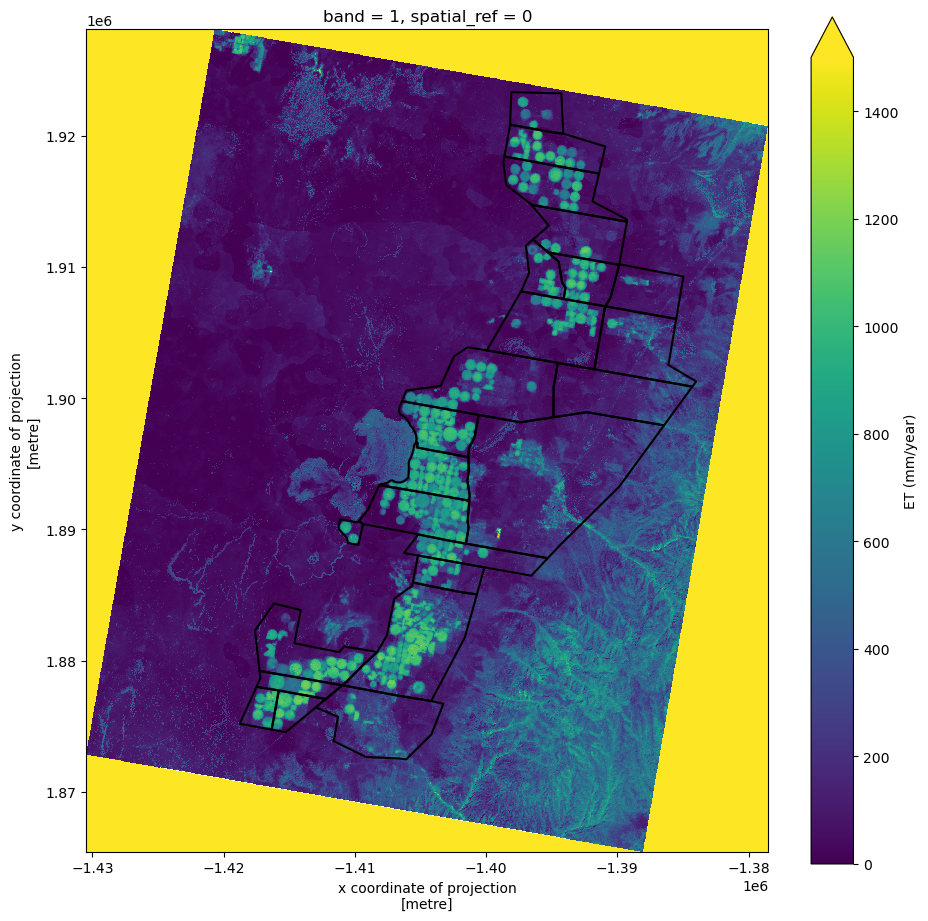

In [10]:
f, ax = plt.subplots(figsize=(11, 11))
et_ir_2022 = rioxarray.open_rasterio(short_term_ir_eem / "eemetric_ag_2022.tif", 
                                     masked=True, mask_and_scale=True).squeeze().rio.reproject(wrlu.crs)
et_ir_2022.plot.imshow(vmin=0,vmax=1500,ax=ax,cbar_kwargs={"label": "ET (mm/year)"})
wrlu.boundary.plot(ax=ax,color='black')

In [12]:
def calc_zonal_stats(varib, rast_dir, wrlu):
    """Combines rasters in a folder into one xarray object.  Uses zonal statistics to summarize a polygon dataset.
    * From: https://corteva.github.io/geocube/html/examples/zonal_statistics.html
    
    varib = the variable name you want to assign to the zonal statistics columns; columns are mean and std
    rast_dir = folder with rasters of interest.  Must extend from 2016 to 2022.  If different, modify function
    wrlu = polygon of fields; must include luid field
    
    """
    timelst = []
    xry = []
    
    zone_field = "FID_Ground"
    
    # Open, reproject, clip, and combine rasters.
    for file in rast_dir.glob("*ensemble*.tif"):
        fname = file.name.split('.')[0][1:]
        # open raster
        rast = rioxarray.open_rasterio(file, masked=True, mask_and_scale=True).squeeze()
        # reproject raster to albers
        clipped = rast.rio.reproject(wrlu.crs)
        # pull year from file name and append to list
        timelst.append(int(fname.split("_")[-3]))
        #timelst.append(int(fname.split("_")[-1]))
        xry.append(clipped)

    # combine rasters into xarray dataset
    da = xarray.concat(xry, dim=timelst).sortby("concat_dim").rename({"concat_dim":"year"})

    # Create the data mask by rasterizing the unique ID of the vector data
    # ensure the vector data are on the same grid as the stacked raster data
    out_grid = make_geocube(vector_data=wrlu, measurements=[zone_field], like=da) 

    # Perform Zonal Statistics (Mean and Std Dev); This will result in a multi-index df with LUID and year
    out_grid["vals"] = (da.dims, da.values, da.attrs, da.encoding)
    grouped_data = out_grid.drop("spatial_ref").groupby(out_grid[zone_field])
    grid_mean = grouped_data.mean().rename({"vals": f"{varib}_mean"})
    grid_std = grouped_data.std().rename({"vals": f"{varib}_std"})

    zone_stat = xarray.merge([grid_mean, grid_std]).to_dataframe()

    zn = zone_stat.rename(index={0:2016,1:2017,2:2018,3:2019,4:2020,5:2021,6:2022},level=1)
    #zn = zone_stat.rename(index={0:2020,1:2021,2:2022},level=1)
    
    if 'spatial_ref' in zn.columns:
        zn = zn.drop(['spatial_ref'],axis=1)
    
    return zn

def calc_zonal_stats_new_rast(varib, rast_dir, wrlu):
    """Combines rasters in a folder into one xarray object.  Uses zonal statistics to summarize a polygon dataset.
    * From: https://corteva.github.io/geocube/html/examples/zonal_statistics.html
    
    varib = the variable name you want to assign to the zonal statistics columns; columns are mean and std
    rast_dir = folder with rasters of interest.  Must extend from 2016 to 2022.  If different, modify function
    wrlu = polygon of fields; must include luid field
    
    """
    timelst = []
    xry = []
    
    zone_field = "FID_Ground"
    
    # Open, reproject, clip, and combine rasters.
    for file in rast_dir.glob("*.tif"):
        fname = file.name.split('.')[0][1:]
        # open raster
        rast = rioxarray.open_rasterio(file, masked=True, mask_and_scale=True).squeeze()
        # reproject raster to albers
        clipped = rast.rio.reproject(wrlu.crs)
        # pull year from file name and append to list
        #timelst.append(int(fname.split("_")[-3]))
        timelst.append(int(fname.split("_")[-1]))
        xry.append(clipped)

    # combine rasters into xarray dataset
    da = xarray.concat(xry, dim=timelst).sortby("concat_dim").rename({"concat_dim":"year"})

    # Create the data mask by rasterizing the unique ID of the vector data
    # ensure the vector data are on the same grid as the stacked raster data
    out_grid = make_geocube(vector_data=wrlu, measurements=[zone_field], like=da) 

    # Perform Zonal Statistics (Mean and Std Dev); This will result in a multi-index df with LUID and year
    out_grid["vals"] = (da.dims, da.values, da.attrs, da.encoding)
    grouped_data = out_grid.drop("spatial_ref").groupby(out_grid[zone_field])
    grid_mean = grouped_data.mean().rename({"vals": f"{varib}_mean"})
    grid_std = grouped_data.std().rename({"vals": f"{varib}_std"})

    zone_stat = xarray.merge([grid_mean, grid_std]).to_dataframe()

    #zn = zone_stat.rename(index={0:2016,1:2017,2:2018,3:2019,4:2020,5:2021,6:2022},level=1)
    zn = zone_stat.rename(index={0:2016,1:2017,2:2018,3:2019,4:2020,5:2021,6:2022},level=1)
    
    if 'spatial_ref' in zn.columns:
        zn = zn.drop(['spatial_ref'],axis=1)
    
    return zn



In [13]:
zone_field = "FID_Ground"


ppt_zn = calc_zonal_stats("PPT", short_term_cy_ppt, wrlu)
et_zn = calc_zonal_stats("ETcy", short_term_cy, wrlu)
irret_zn = calc_zonal_stats("ETir", short_term_ir, wrlu)
irret_zn_em = calc_zonal_stats_new_rast("ETirSSE",short_term_ir_sse, wrlu)
irret_zn_se = calc_zonal_stats_new_rast("ETirEEM",short_term_ir_eem, wrlu)
irrppt_zn = calc_zonal_stats("PPTir",short_term_ir_ppt, wrlu)

#zonal_combo = pd.concat([ppt_zn,et_zn,irret_zn,irrppt_zn],axis=1)
zonal_combo = pd.concat([irret_zn,irret_zn_em,irret_zn_se,irrppt_zn,ppt_zn,et_zn],axis=1)
wrlu_zonal = wrlu.merge(zonal_combo.reset_index(), on=zone_field)

In [14]:
wrlu_zonal['Acres'] = wrlu_zonal.geometry.area * 0.000247105 # square meters to acres

#calc_varibs = ["PPT","ETcy","ETir","PPTir"]
calc_varibs = ["ETir","PPTir","ETirSSE","ETirEEM","PPT","ETcy"]

for varib in calc_varibs:

    if varib == 'ETirSSE' or varib == 'ETirEEM':
        conv = 0.00328084
    else:
        conv = 0.0833333
    wrlu_zonal[f'{varib}_acft'] = wrlu_zonal['Acres'] * conv * wrlu_zonal[f'{varib}_mean'] # inches to feet
    wrlu_zonal[f'{varib}_std_acft'] = wrlu_zonal['Acres'] * conv * wrlu_zonal[f'{varib}_std']

wrlu_zonal['Pcnt_IRR_ET'] = wrlu_zonal['ETir_acft']/wrlu_zonal['ETcy_acft']
wrlu_zonal['Pcnt_PPT_ET'] = wrlu_zonal['PPT_acft']/wrlu_zonal['ETcy_acft']
wrlu_zonal['NonIRR_ET'] = wrlu_zonal['ETcy_acft'] - wrlu_zonal['ETir_acft']
wrlu_zonal['ET-PPT'] = wrlu_zonal['ETcy_acft'] - wrlu_zonal['PPT_acft']
wrlu_zonal['ETir-PPTir'] = wrlu_zonal['ETir_acft'] - wrlu_zonal['PPTir_acft']
wrlu_zonal['ETirSSE-PPTir'] = wrlu_zonal['ETirSSE_acft'] - wrlu_zonal['PPTir_acft']
wrlu_zonal['ETirEEM-PPTir'] = wrlu_zonal['ETirEEM_acft'] - wrlu_zonal['PPTir_acft']
#yrdata[yr] = wrlu_zonal

In [15]:
cons_use

NameError: name 'cons_use' is not defined

Text(0, 0.5, 'Probability Distribution')

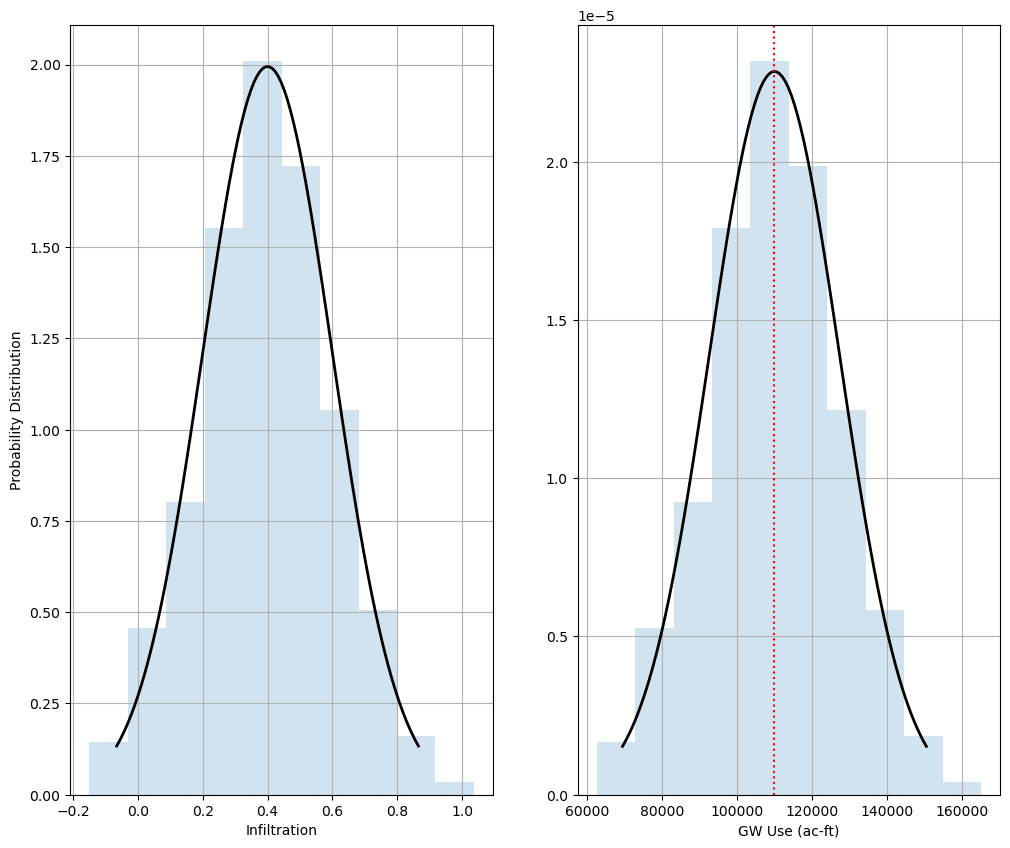

In [76]:
wu_2021 = wrlu_zonal[wrlu_zonal['year']==2021]
cons_use = wu_2021.groupby('Name').sum(numeric_only=True)[['ETir-PPTir','ETirSSE-PPTir','ETirEEM-PPTir']].sum()
#print(cons_use)

fig, ax = plt.subplots(1,2)

gw_reg_2021 = wu_2021.set_index('FID_Ground').sort_index()[['Name','ETirSSE-PPTir','Acres']]
surf_irr_est_2021 = gw_reg_2021.loc[[11,17,20,9],'ETirSSE-PPTir'].sum()


infil_perc = stats.norm(0.4,0.2)
infil_samp = infil_perc.rvs(size = 1000)

x = np.linspace(infil_perc.ppf(0.01), infil_perc.ppf(0.99), 100)
ax[0].plot(x, infil_perc.pdf(x), 'k-', lw=2, label='Lognormal PDF')
ax[0].hist(infil_samp, density=True, alpha = 0.2)
ax[0].set_xlabel('Infiltration')
ax[0].grid()

et_data = cons_use['ETirSSE-PPTir'] + infil_samp*cons_use['ETirSSE-PPTir'] - surf_irr_est_2021 
cons_stats = stats.norm.fit(et_data)
cons_dist = stats.norm(*cons_stats)
cons_dist.mean()

#print(et_data.mean())
ax[1].hist(et_data, density=True, alpha = 0.2)
x1 = np.linspace(cons_dist.ppf(0.01), cons_dist.ppf(0.99), 100)
ax[1].plot(x1, cons_dist.pdf(x1), 'k-', lw=2, label='Lognormal PDF')
ax[1].axvline(et_data.mean(), color='red',linestyle=":")
ax[1].set_xlabel('GW Use (ac-ft)')
ax[1].grid()
ax[0].set_ylabel('Probability Distribution')

In [91]:
cons_use

ETir-PPTir       78650.571872
ETirSSE-PPTir    86573.623102
ETirEEM-PPTir    75084.045062
dtype: float64

Text(0, 0.5, 'Probability Distribution')

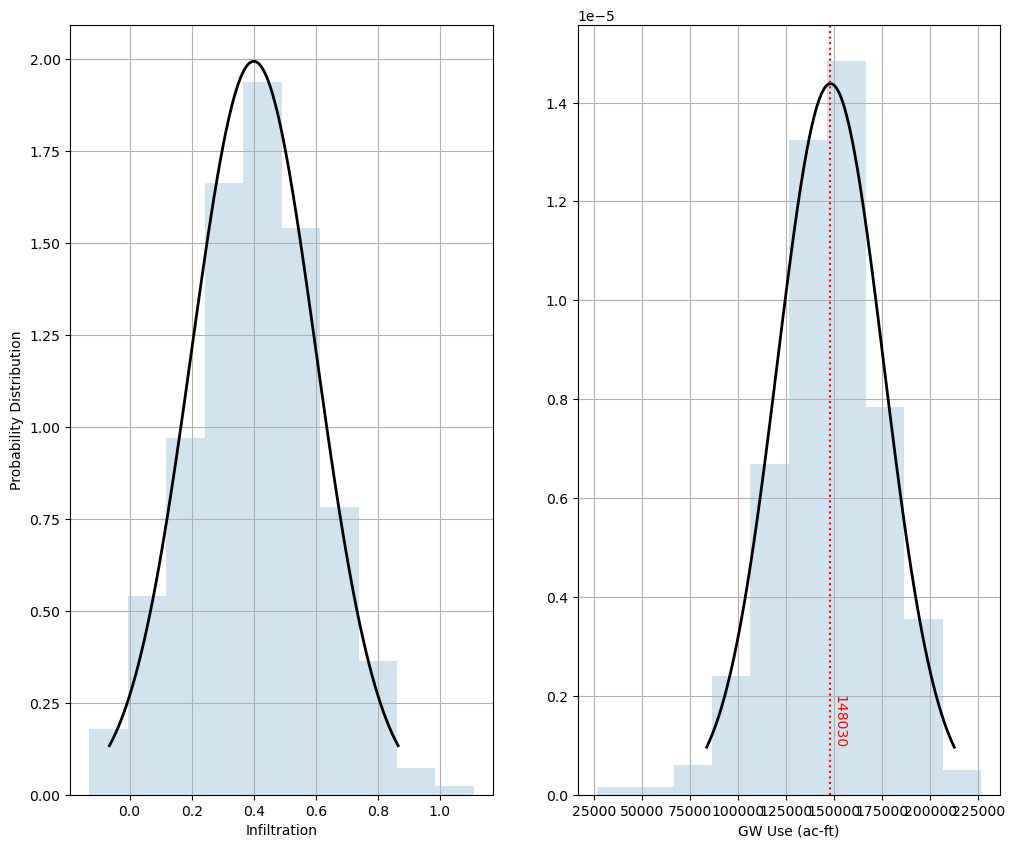

In [86]:
wu_2022 = wrlu_zonal[wrlu_zonal['year']==2022]
cons_use = wu_2022.groupby('Name').sum(numeric_only=True)['ETirSSE-PPTir'].sum()
#print(cons_use)

gw_reg_2022 = wu_2022.set_index('FID_Ground').sort_index()[['Name','ETirSSE-PPTir','Acres']]
surf_irr_est_2022 = gw_reg_2022.loc[[11,17,20,9],'ETirSSE-PPTir'].sum()

fig, ax = plt.subplots(1,2)

canal_crks = terra_mo.loc[[51,43,27],'terra_ro_acft'].groupby(level=1).sum()
canal_crks_irr_mo = canal_crks[canal_crks.index.month.isin([3,4,5,6,7,8,9,10])]
canal_crks_irr_year = canal_crks_irr_mo.groupby(pd.Grouper(level=0,freq='1Y')).sum()

lognm = stats.lognorm.fit(canal_crks_irr_year)
canaldist = stats.lognorm(*lognm)

infil_perc = stats.norm(0.4,0.2)
infil_samp = infil_perc.rvs(size = 1000)

x = np.linspace(infil_perc.ppf(0.01), infil_perc.ppf(0.99), 100)
ax[0].plot(x, infil_perc.pdf(x), 'k-', lw=2, label='Lognormal PDF')
ax[0].hist(infil_samp, density=True, alpha = 0.2)
ax[0].set_xlabel('Infiltration')
ax[0].grid()

et_data = cons_use + infil_samp*cons_use - canaldist.rvs(size=1000)
cons_stats = stats.norm.fit(et_data)
cons_dist = stats.norm(*cons_stats)
cons_dist.mean()


#print(et_data.mean())
ax[1].hist(et_data, density=True, alpha = 0.2)
x1 = np.linspace(cons_dist.ppf(0.01), cons_dist.ppf(0.99), 100)
ax[1].plot(x1, cons_dist.pdf(x1), 'k-', lw=2, label='Lognormal PDF')
ax[1].axvline(et_data.mean(), color='red',linestyle=":")
ax[1].text(et_data.mean()+1000,0.1e-5,f"{et_data.mean():0.0f}",color='red',rotation=-90)
ax[1].set_xlabel('GW Use (ac-ft)')
ax[1].grid()

ax[0].set_ylabel('Probability Distribution')

In [89]:
surf_irr_est_2022

21526.78932220484

In [87]:

confidence = 0.95
print(f"{confidence*100:0.0f}% confidence interval between {infil_perc.interval(confidence)[0]:0.0f} and {infil_perc.interval(confidence)[-1]:0.0f} %")
print(f"Median: {infil_perc.median()}")

95% confidence interval between 0 and 1 %
Median: 0.4


In [47]:
wu_2022.groupby('Name').sum(numeric_only=True)['ETirSSE-PPTir']

Name
Flowell      39326.864203
Greenwood    18467.335375
Kanosh       14901.050900
McCornick    11629.797676
Meadow       22422.457942
Pavant        9806.852916
Name: ETirSSE-PPTir, dtype: float64

In [48]:
wu_2022.groupby('Name').sum(numeric_only=True)['ETirEEM-PPTir'].sum()

92558.90823282441

In [22]:
wu_2022.groupby('Name').sum(numeric_only=True)['ETir-PPTir'].sum()

107573.719279794

In [23]:
wu_2022.groupby('Name').sum(numeric_only=True)['ETirSSE-PPTir'].sum()

116554.3590123525

In [25]:
gw_reg_2022 = wu_2022.set_index('FID_Ground').sort_index()[['Name','ETirSSE-PPTir','Acres']]
gw_reg_2022['ft cons use'] = gw_reg_2022['ETirSSE-PPTir']/gw_reg_2022['Acres']
gw_reg_2022

,Name,ETirSSE-PPTir,Acres,ft cons use
FID_Ground,,,,
1,McCornick,1150.835163,2708.392301,0.424915
2,McCornick,4766.892500,4382.421971,1.087730
3,McCornick,5712.070013,5685.732682,1.004632
4,Greenwood,2578.777801,5283.702286,0.488063
5,Greenwood,2316.999362,2318.935467,0.999165
6,Greenwood,3871.483818,3317.625805,1.166944
7,Greenwood,649.126542,4211.191316,0.154143
8,Greenwood,5364.216317,8926.851582,0.600908
9,Greenwood,3686.731535,7116.691174,0.518040


In [46]:
print(et_data.mean())

95253.39954855254


In [26]:
surf_irr_est_2022 = gw_reg_2022.loc[[11,17,20],'ETirSSE-PPTir'].sum()
gw_reg_2022.loc[:,'ETirSSE-PPTir'].sum() - surf_irr_est_2022

98714.30122549299

In [27]:
surf_irr_est_2022

17840.05778685951

In [29]:
project_path = pathlib.Path("G:/Shared Drives/UGS_Groundwater/Projects/Pahvant_Valley/")
budget_data_path = project_path / "Pahvant_Basins" / "GEE_out" / "byhydrodiv"

In [30]:
terra_mo = pd.read_parquet(budget_data_path / "terra_mo_hydrodiv.parquet")
terra_mo = terra_mo.reset_index().groupby(['hucname','date']).mean()

In [59]:
chkflw
         

2     21806.0
3     26806.0
4      5784.0
5     11838.0
7       100.0
8       966.0
9      1880.0
10    14364.0
11     8812.0
12    29255.0
13     2352.0
14    14194.0
15    33776.0
16    13694.0
17     1930.0
18     3492.0
19        0.0
20     8279.0
21     9361.0
22    11113.0
24     5168.0
25    10753.0
26     8156.0
27    18192.0
28    34067.0
29     4145.0
30     8336.0
31     3578.0
32     2371.0
33     8572.0
34    14614.0
35     1747.0
36    32928.0
37     2515.0
39       22.0
40       80.0
41     2515.0
Name: Total Flow Acre Feet, dtype: float64

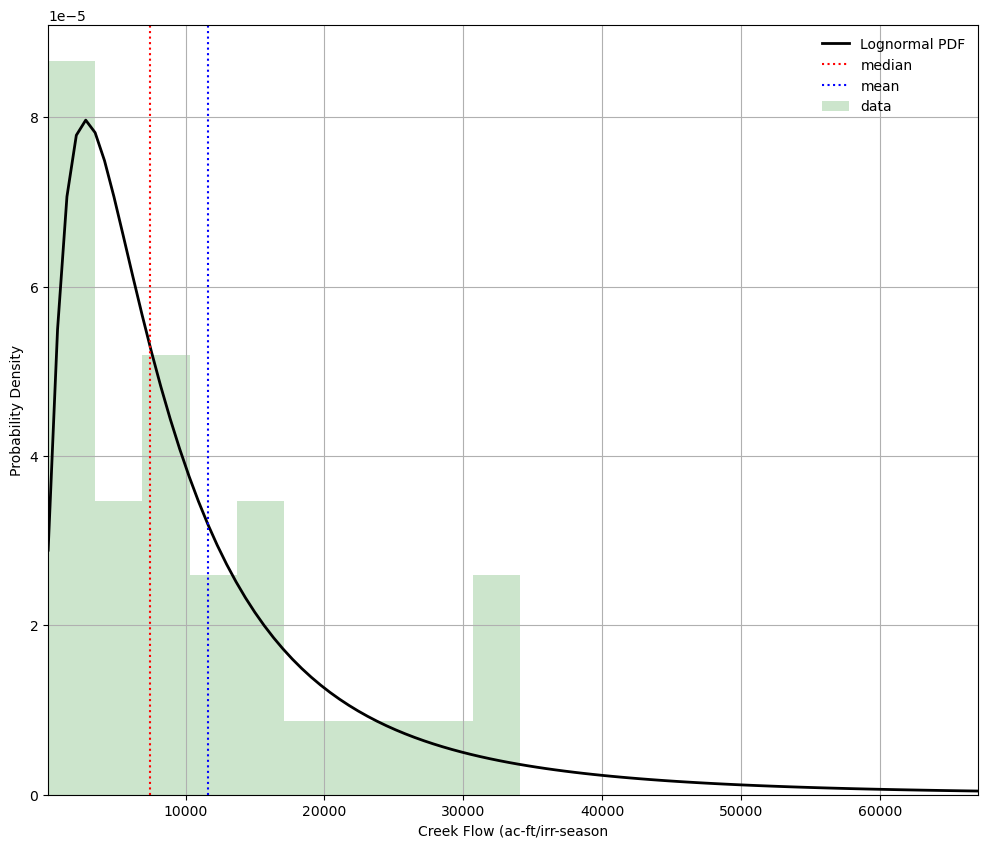

probability of being close to 10000: 15.67 %
95% confidence interval between 512 and 47928 acre-ft
Median: 7428.406343507238


In [61]:
chalkirrfile = r"G:\Shared drives\UGS_Groundwater\Projects\Pahvant_Valley\Flow Monitoring\Chalk Creek Irr. Co. - Historical Records.xlsx"
chalkirr = pd.read_excel(chalkirrfile, "Sheet1",skiprows=1)
chkflw = chalkirr['Total Flow Acre Feet'].drop([19,39,40]).dropna()[2:]

lognm = stats.lognorm.fit(chkflw)
chkirrdist = stats.lognorm(*lognm)

fig, ax = plt.subplots(1, 1)
r = chkirrdist.rvs(size=1000)
x = np.linspace(chkirrdist.ppf(0.01), chkirrdist.ppf(0.99), 100)
ax.plot(x, chkirrdist.pdf(x), 'k-', lw=2, label='Lognormal PDF')
#ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.axvline(chkirrdist.median(),label='median',color='red',linestyle=":")
ax.axvline(chkirrdist.mean(),label='mean',color='blue',linestyle=":")
chkflw.hist(density=True,ax=ax, color='green',alpha=0.2,label='data')
#ax.axvspan(*testdist.interval(0.80),alpha=0.2,color='green')
ax.set_xlim([x[0], x[-1]])
ax.set_xlabel("Creek Flow (ac-ft/irr-season")
ax.set_ylabel("Probability Density")
ax.legend(loc='best', frameon=False)
plt.show()

val = 10000
eps = 2000
prob_close_to_val = chkirrdist.cdf(val + eps) - chkirrdist.cdf(val - eps)
print(f"probability of being close to {val}: {prob_close_to_val * 100:.2f} %")
# probability of being close to 0.5: 12.95 %
confidence = 0.95
print(f"{confidence*100:0.0f}% confidence interval between {chkirrdist.interval(confidence)[0]:0.0f} and {chkirrdist.interval(confidence)[-1]:0.0f} acre-ft")
print(f"Median: {chkirrdist.median()}")

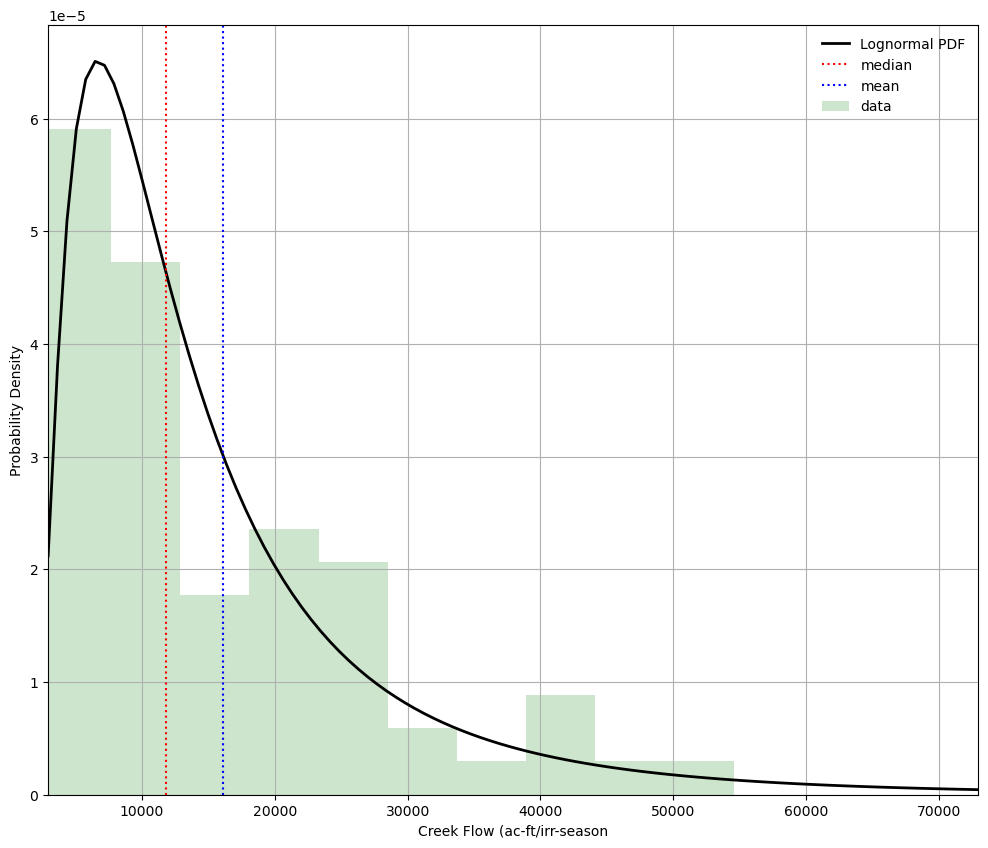

probability of being close to 10000: 21.77 %
95% confidence interval between 3462 and 54230 acre-ft
Median: 11825.544333982696


In [45]:

canal_crks = terra_mo.loc[[51,43,27],'terra_ro_acft'].groupby(level=1).sum()
canal_crks_irr_mo = canal_crks[canal_crks.index.month.isin([3,4,5,6,7,8,9,10])]
canal_crks_irr_year = canal_crks_irr_mo.groupby(pd.Grouper(level=0,freq='1Y')).sum()

lognm = stats.lognorm.fit(canal_crks_irr_year)
canaldist = stats.lognorm(*lognm)

fig, ax = plt.subplots(1, 1)
r = canaldist.rvs(size=1000)
x = np.linspace(canaldist.ppf(0.01), canaldist.ppf(0.99), 100)
ax.plot(x, canaldist.pdf(x), 'k-', lw=2, label='Lognormal PDF')
#ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.axvline(canaldist.median(),label='median',color='red',linestyle=":")
ax.axvline(canaldist.mean(),label='mean',color='blue',linestyle=":")
canal_crks_irr_year.hist(density=True,ax=ax, color='green',alpha=0.2,label='data')
#ax.axvspan(*testdist.interval(0.80),alpha=0.2,color='green')
ax.set_xlim([x[0], x[-1]])
ax.set_xlabel("Creek Flow (ac-ft/irr-season")
ax.set_ylabel("Probability Density")
ax.legend(loc='best', frameon=False)
plt.show()

val = 10000
eps = 2000
prob_close_to_val = canaldist.cdf(val + eps) - canaldist.cdf(val - eps)
print(f"probability of being close to {val}: {prob_close_to_val * 100:.2f} %")
# probability of being close to 0.5: 12.95 %
confidence = 0.95
print(f"{confidence*100:0.0f}% confidence interval between {canaldist.interval(confidence)[0]:0.0f} and {canaldist.interval(confidence)[-1]:0.0f} acre-ft")
print(f"Median: {canaldist.median()}")

In [ ]:
chalk = terra_mo.loc[27,'terra_ro_acft']
chalk_irr_mo = chalk[chalk.index.month.isin([3,4,5,6,7,8,9,10])]#.groupby(
chalk_irr_mo.groupby(pd.Grouper(level=0,freq='1Y')).sum().hist()

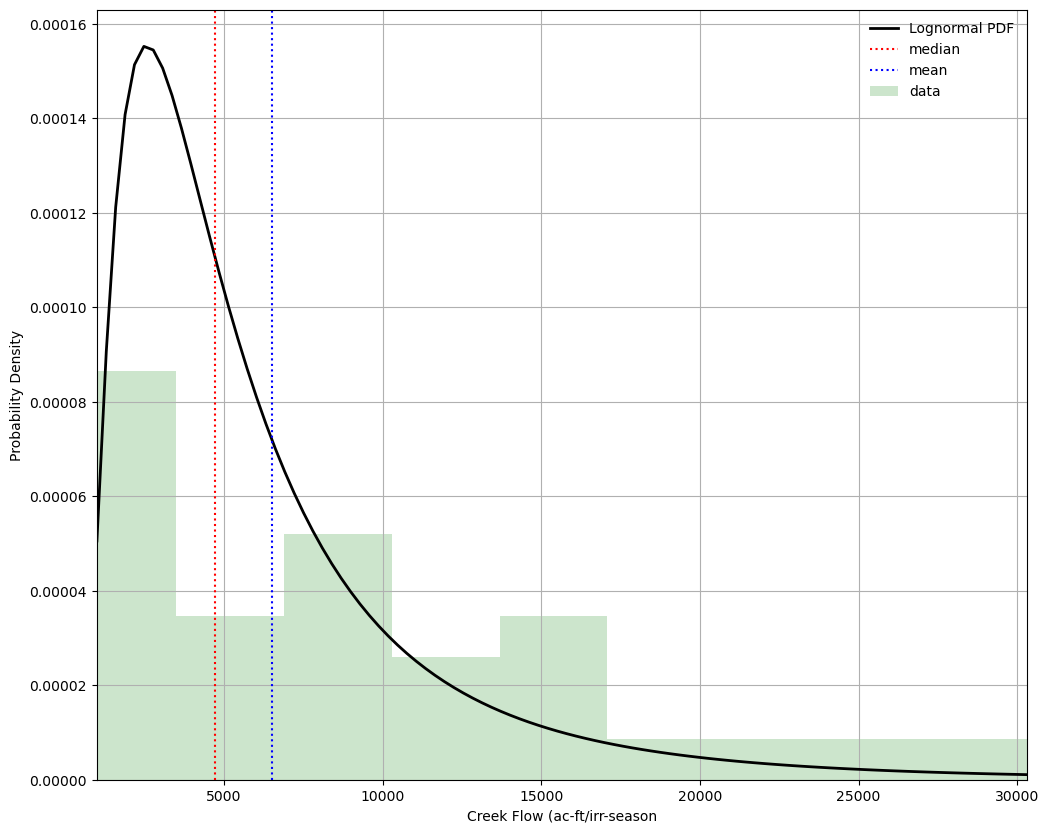

probability of being close to 10000: 13.16 %
95% confidence interval between 1224 and 22472 acre-ft
Median: 4729.385831412295


In [64]:
chalk = terra_mo.loc[27,'terra_ro_acft']
chalk_irr_mo = chalk[chalk.index.month.isin([3,4,5,6,7,8,9,10])]#.groupby(
chalk_irr_yr = chalk_irr_mo.groupby(pd.Grouper(level=0,freq='1Y')).sum()

lognm = stats.lognorm.fit(chalk_irr_yr)
chalk_irrdist = stats.lognorm(*lognm)

fig, ax = plt.subplots(1, 1)
r = chalk_irrdist.rvs(size=1000)
x = np.linspace(chalk_irrdist.ppf(0.01), chalk_irrdist.ppf(0.99), 100)
ax.plot(x, chalk_irrdist.pdf(x), 'k-', lw=2, label='Lognormal PDF')
#ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.axvline(chalk_irrdist.median(),label='median',color='red',linestyle=":")
ax.axvline(chalk_irrdist.mean(),label='mean',color='blue',linestyle=":")
chkflw.hist(density=True,ax=ax, color='green',alpha=0.2,label='data')
#ax.axvspan(*testdist.interval(0.80),alpha=0.2,color='green')
ax.set_xlim([x[0], x[-1]])
ax.set_xlabel("Creek Flow (ac-ft/irr-season")
ax.set_ylabel("Probability Density")
ax.legend(loc='best', frameon=False)
plt.show()

val = 10000
eps = 2000
prob_close_to_val = chalk_irrdist.cdf(val + eps) - chalk_irrdist.cdf(val - eps)
print(f"probability of being close to {val}: {prob_close_to_val * 100:.2f} %")
# probability of being close to 0.5: 12.95 %
confidence = 0.95
print(f"{confidence*100:0.0f}% confidence interval between {chalk_irrdist.interval(confidence)[0]:0.0f} and {chalk_irrdist.interval(confidence)[-1]:0.0f} acre-ft")
print(f"Median: {chalk_irrdist.median()}")

datetime
1944-12-31    35619.264881
1945-12-31    29847.349256
1946-12-31    16754.026428
1947-12-31    31106.856617
1948-12-31    26515.109307
1949-12-31    17434.557099
1950-12-31    17367.317257
1951-12-31     7801.606780
1952-12-31    42216.306589
1953-12-31    20388.151449
1954-12-31    10704.225793
1955-12-31    13967.044076
1956-12-31    11060.656459
1957-12-31    31293.303376
1958-12-31    23153.117216
1959-12-31     6805.505053
1960-12-31    14190.581839
1961-12-31     9103.758879
1962-12-31    23893.747214
1963-12-31     7977.937811
1964-12-31    19568.579099
1965-12-31    22195.098230
1966-12-31    11393.880454
1967-12-31    14449.028783
1968-12-31    28004.699903
1969-12-31    21235.095769
1970-12-31    23652.953208
1971-12-31    21965.014996
Freq: A-DEC, Name: cfd, dtype: float64

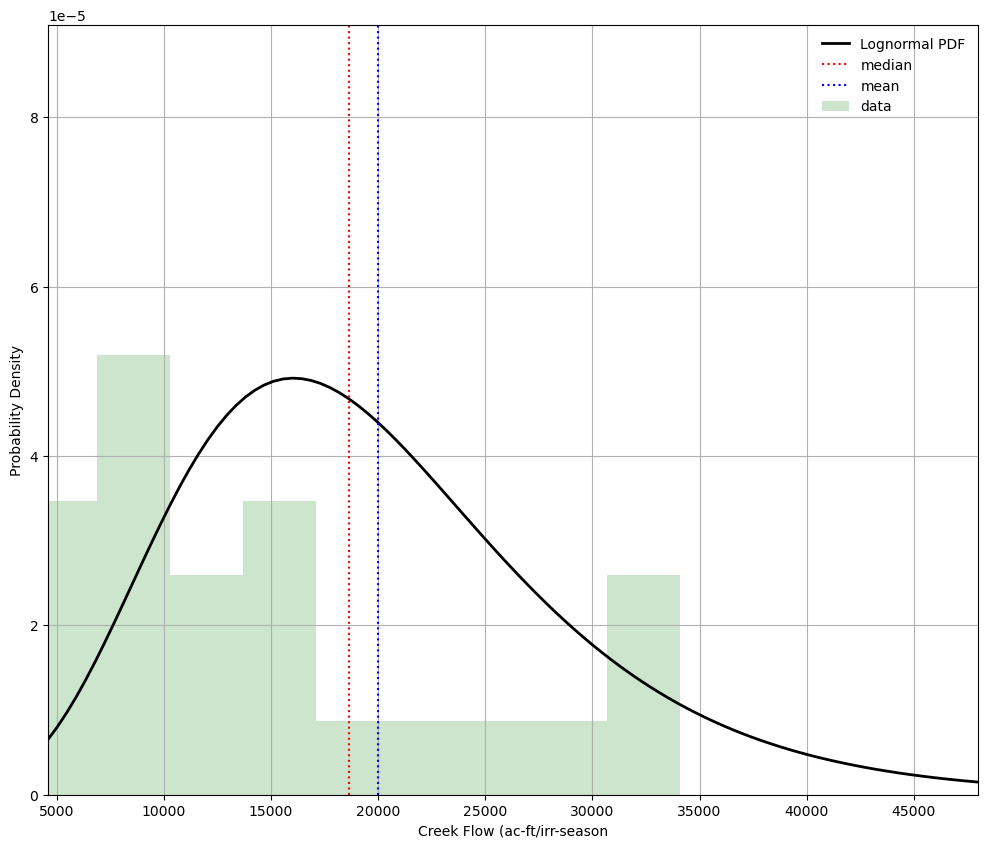

probability of being close to 10000: 12.99 %
95% confidence interval between 6177 and 41822 acre-ft
Median: 18621.147327609746


In [71]:
url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=10232500&legacy=&referred_module=sw&period=&begin_date=1944-03-01&end_date=1971-09-29"

chalk = pd.read_table(url,comment="#")
chalk = chalk.drop([0],axis=0)
chalk['datetime'] = pd.to_datetime(chalk['datetime'])
chalk = chalk.rename(columns = {'143838_00060_00003':'cfs'})
chalk['cfs'] = pd.to_numeric(chalk['cfs'])
chalk['cfd'] = 86400*chalk['cfs']
chalk = chalk.drop(['agency_cd','143838_00060_00003_cd','site_no'],axis=1)
chalk = chalk.set_index('datetime')

chalk = chalk.resample('1D').asfreq().interpolate(method='time')
#chalk['water year'] = chalk.index.shift(-9, freq='M').year+1 

chalk_irr_mo = chalk[chalk.index.month.isin([3,4,5,6,7,8,9,10])]#.groupby(
chalk_irr_yr = chalk_irr_mo.groupby(pd.Grouper(level=0,freq='1Y')).sum().dropna()['cfd']*2.29569e-5


lognm = stats.lognorm.fit(chalk_irr_yr)
chalk_irrdist = stats.lognorm(*lognm)

fig, ax = plt.subplots(1, 1)
r = chalk_irrdist.rvs(size=1000)
x = np.linspace(chalk_irrdist.ppf(0.01), chalk_irrdist.ppf(0.99), 100)
ax.plot(x, chalk_irrdist.pdf(x), 'k-', lw=2, label='Lognormal PDF')
#ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.axvline(chalk_irrdist.median(),label='median',color='red',linestyle=":")
ax.axvline(chalk_irrdist.mean(),label='mean',color='blue',linestyle=":")
chkflw.hist(density=True,ax=ax, color='green',alpha=0.2,label='data')
#ax.axvspan(*testdist.interval(0.80),alpha=0.2,color='green')
ax.set_xlim([x[0], x[-1]])
ax.set_xlabel("Creek Flow (ac-ft/irr-season")
ax.set_ylabel("Probability Density")
ax.legend(loc='best', frameon=False)
plt.show()

val = 10000
eps = 2000
prob_close_to_val = chalk_irrdist.cdf(val + eps) - chalk_irrdist.cdf(val - eps)
print(f"probability of being close to {val}: {prob_close_to_val * 100:.2f} %")
# probability of being close to 0.5: 12.95 %
confidence = 0.95
print(f"{confidence*100:0.0f}% confidence interval between {chalk_irrdist.interval(confidence)[0]:0.0f} and {chalk_irrdist.interval(confidence)[-1]:0.0f} acre-ft")
print(f"Median: {chalk_irrdist.median()}")


<Axes: >

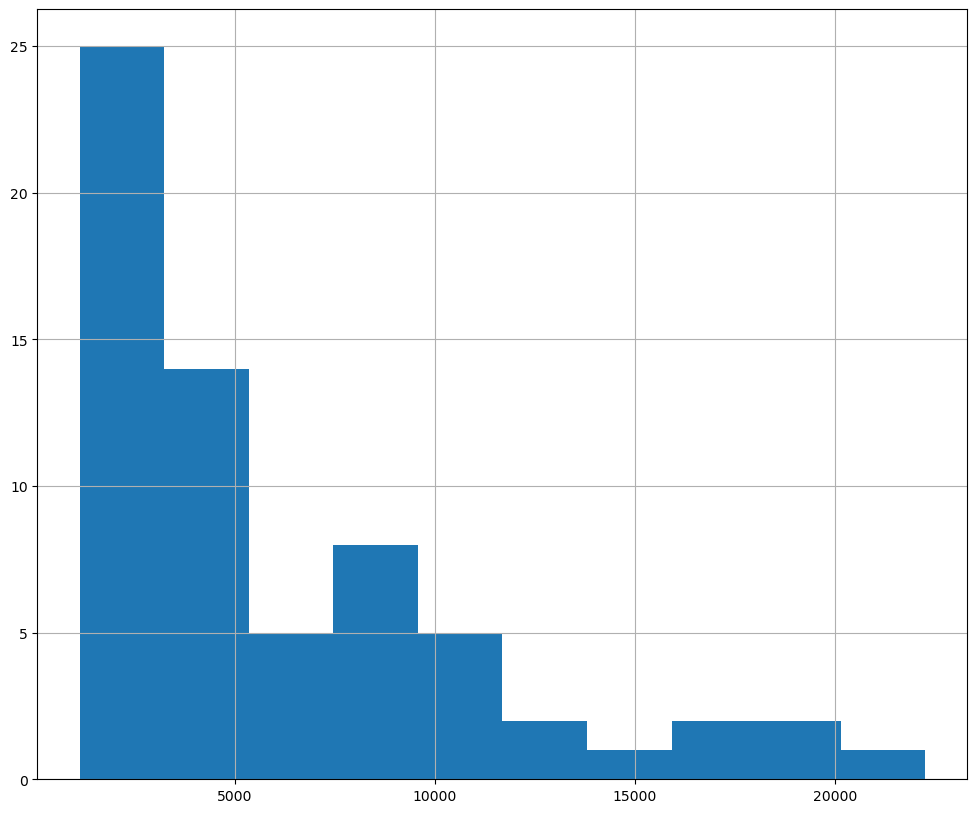

In [38]:
corn = terra_mo.loc[43,'terra_ro_acft']
corn_irr_mo = corn[corn.index.month.isin([3,4,5,6,7,8,9,10])]#.groupby(
corn_irr_mo.groupby(pd.Grouper(level=0,freq='1Y')).sum().hist()